### Install dependencies (if running in notebook)
# !pip install scikit-learn xgboost matplotlib

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pickle
!pip install scikit-learn xgboost matplotlib

In [2]:
# Load data
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Base models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [10]:
# Parameter grids
param_grids = {
    'lr': {'logisticregression__C': [0.1, 1, 10]},
    'rf': {'randomforestclassifier__n_estimators': [50, 100], 'randomforestclassifier__max_depth': [3, 5, None]},
    'xgb': {'xgbclassifier__n_estimators': [50, 100], 'xgbclassifier__learning_rate': [0.01, 0.1, 0.3]},
    'svc': {'svc__C': [0.1, 1], 'svc__kernel': ['linear', 'rbf']}
}

In [11]:
# Pipelines
pipelines = {
    'lr': make_pipeline(StandardScaler(), LogisticRegression()),
    'rf': make_pipeline(StandardScaler(), RandomForestClassifier()),
    'xgb': make_pipeline(StandardScaler(), XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    'svc': make_pipeline(StandardScaler(), SVC(probability=True))
}

In [12]:
best_models = {}
accuracies = {}


In [14]:
for name, pipe in pipelines.items():
    print(f"Tuning {name}...")
    grid = GridSearchCV(pipe, param_grids[name], cv=5, scoring='accuracy')
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    pred = grid.predict(X_test)
    acc = accuracy_score(y_test, pred)
    accuracies[name] = acc
    print(f"{name} Accuracy: {acc:.4f} | Best Params: {grid.best_params_}")

Tuning lr...
lr Accuracy: 0.9737 | Best Params: {'logisticregression__C': 1}
Tuning rf...
rf Accuracy: 0.9649 | Best Params: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__n_estimators': 100}
Tuning xgb...


C:\Users\Koushik SM\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:08:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Koushik SM\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:08:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Koushik SM\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:08:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Koushik SM\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:08:1

xgb Accuracy: 0.9561 | Best Params: {'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__n_estimators': 100}
Tuning svc...
svc Accuracy: 0.9825 | Best Params: {'svc__C': 0.1, 'svc__kernel': 'linear'}


In [15]:
# Voting Classifier (soft)
voting_clf = VotingClassifier(
    estimators=[
        ('lr', best_models['lr']),
        ('rf', best_models['rf']),
        ('xgb', best_models['xgb']),
        ('svc', best_models['svc'])
    ],
    voting='soft'
)
voting_clf.fit(X_train, y_train)
voting_pred = voting_clf.predict(X_test)
voting_acc = accuracy_score(y_test, voting_pred)
accuracies['Voting Ensemble'] = voting_acc
print(f"Voting Ensemble Accuracy: {voting_acc:.4f}")


C:\Users\Koushik SM\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:08:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Voting Ensemble Accuracy: 0.9649


In [16]:
# Stacking Classifier
stack_clf = StackingClassifier(
    estimators=[
        ('lr', best_models['lr']),
        ('rf', best_models['rf']),
        ('xgb', best_models['xgb'])
    ],
    final_estimator=GaussianNB()
)
stack_clf.fit(X_train, y_train)
stack_pred = stack_clf.predict(X_test)
stack_acc = accuracy_score(y_test, stack_pred)
accuracies['Stacking Ensemble'] = stack_acc
print(f"Stacking Ensemble Accuracy: {stack_acc:.4f}")

C:\Users\Koushik SM\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:08:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Koushik SM\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:08:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Koushik SM\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:08:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Koushik SM\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:08:4

Stacking Ensemble Accuracy: 0.9649


In [17]:
# Save best ensemble model
final_best_model = stack_clf if stack_acc > voting_acc else voting_clf
with open('best_ensemble_model.pkl', 'wb') as f:
    pickle.dump(final_best_model, f)
print(f"\n✅ Saved best ensemble model: {'Stacking' if stack_acc > voting_acc else 'Voting'}")


✅ Saved best ensemble model: Voting


In [18]:
# Load model (for deployment test)
# with open('best_model.pkl', 'rb') as f:
#     loaded_model = pickle.load(f)
#     print("Loaded model prediction sample:", loaded_model.predict(X_test[:1]))

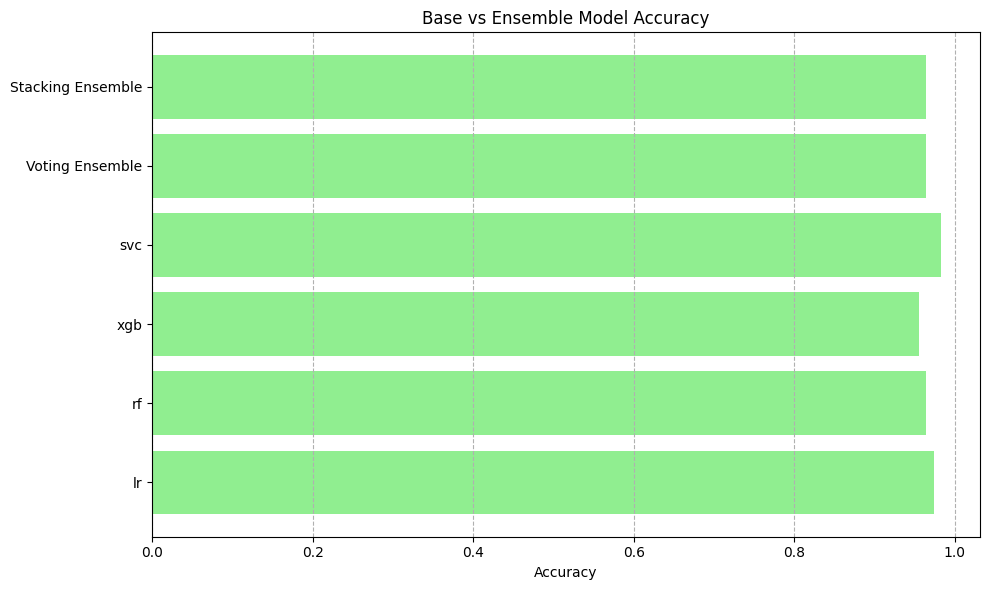

In [19]:
# Plot accuracies
plt.figure(figsize=(10, 6))
plt.barh(list(accuracies.keys()), list(accuracies.values()), color='lightgreen')
plt.xlabel("Accuracy")
plt.title("Base vs Ensemble Model Accuracy")
plt.grid(axis='x', linestyle='--')
plt.tight_layout()
plt.show()